### Imports and Installs

In [ ]:
%%capture
! pip install nba_api
! pip install pandas
! pip install requests

In [7]:
import json
import nba_api
import requests
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd
import time
import os
import glob

In [8]:
nba_season = '2020-21'
season_type = 'Regular Season'
path_API_download =  "/Users/rishabhpatni/Desktop/Projects/nba-play-by-play-probability-generator/all_plays.csv"
path_defender_directory = "/Users/rishabhpatni/Desktop/Projects/nba-play-by-play-probability-generator/Data/"

## Creating dataset
Note that this data is for exclusively the 2020-21 nba season.

In [9]:
# Get team ID based on team name
def get_team_id(team):
    for team1 in teams:
        if team1['abbreviation'] == team:
            return team1['teamId']
    return -1

# Get player ID based on player name
def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return [player['playerId'], player["teamId"]]
    return -1

In [117]:
class PlayByPlayNBAApiDataset():
    def __init__(self, defender_distance_data = path_defender_directory, file_path = None):
        self.data= []
        self.len = 0
        data = pd.DataFrame(columns = ["GRID_TYPE", "gameid", "eventnum", "PLAYER_ID",
                                           "PLAYER_NAME", "TEAM_ID", "TEAM_NAME", "PERIOD", "MINUTES_REMAINING",
                                           "SECONDS_REMAINING", "SHOT_ZONE_AREA", "SHOT_ZONE_RANGE", "SHOT_DISTANCE",
                                           "LOC_X", "LOC_Y", "SHOT_ATTEMPTED_FLAG", "SHOT_MADE_FLAG", "GAME_DATE",
                                           "HTM", "VTM"])
        teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
        players = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/players.json').text)
        
        if (file_path == None):
            counter = 0
            for player in players: 
                counter +=1;
                if counter%10 == 0:
                    time.sleep(15)

                if counter%50 == 0:
                    time.sleep(45)
                    print(f"{counter} player's shot data has been parsed through.")

                if (player["teamId"] == 0):
                    continue

                response = shotchartdetail.ShotChartDetail(
                    context_measure_simple = 'FGA',
                    team_id=player["teamId"],
                    player_id=player["playerId"],
                    season_nullable=nba_season,
                    season_type_all_star=season_type).get_data_frames()[0]

                if response.shape[0] < 200: 
                    continue

                else:
                    data = pd.concat([data, response], ignore_index = True)
            pd.to_csv('final_values.csv')
        else:
            data = pd.read_csv(file_path)[["GRID_TYPE", "GAME_ID", "GAME_EVENT_ID", "PLAYER_ID",
                                           "PLAYER_NAME", "TEAM_ID", "TEAM_NAME", "PERIOD", "MINUTES_REMAINING",
                                           "SECONDS_REMAINING", "SHOT_ZONE_AREA", "SHOT_ZONE_RANGE", "SHOT_DISTANCE",
                                           "LOC_X", "LOC_Y", "SHOT_ATTEMPTED_FLAG", "SHOT_MADE_FLAG", "GAME_DATE",
                                           "HTM", "VTM"]]
            data.columns = ["GRID_TYPE", "gameid", "eventnum", "PLAYER_ID",
                                           "PLAYER_NAME", "TEAM_ID", "TEAM_NAME", "PERIOD", "MINUTES_REMAINING",
                                           "SECONDS_REMAINING", "SHOT_ZONE_AREA", "SHOT_ZONE_RANGE", "SHOT_DISTANCE",
                                           "x", "y", "SHOT_ATTEMPTED_FLAG", "SHOT_MADE_FLAG", "GAME_DATE",
                                           "HTM", "VTM"]
        
        
        files = glob.glob(os.path.join(defender_distance_data + "/*.csv"))
        # joining files with concat and read_csv
        defender_distance_data = pd.concat(map(pd.read_csv, files), ignore_index=True)
        defender_distance_data["shot_clock"] = 24 - (defender_distance_data["possession_start_time"] - defender_distance_data["time"])
        defender_distance_data = defender_distance_data[["gameid", "eventnum", "date", "player", 
                                                         "team", "opponent", "period", "time", 
                                                         "x", "y", "dribble_range", 
                                                         "touch_time", "closest_def_dist", "value", "made", 
                                                         "margin", "assisted", "assist_player" ,"shottype", "and1"]]
        
        defender_distance_data["time"] = defender_distance_data["time"].apply(lambda x: time.strftime("%M:%S", time.gmtime(x)))

        data = data.merge(defender_distance_data, on = ["gameid", "eventnum","x", "y"], how='left')
        data = data[["PLAYER_NAME", "TEAM_NAME", "PERIOD", "time", "SHOT_ZONE_AREA", "SHOT_DISTANCE","opponent", "x", "y", "dribble_range", "touch_time", "closest_def_dist", "value", "made", "margin", "shottype"]]
        data = data.dropna()
        data.columns = ["player_name", "team_name", "period", "time", "shot_zone", "shot_distance","opponent", "x", "y", "dribble_range", "touch_time", "closest_def_dist", "value", "made", "margin" ,"shot_type"]
        self.data = data
        self.len = data.shape[0]

        
    def __len__(self):
        return self.len


## Exploratory Data Analysis

In [101]:
dataset = PlayByPlayNBAApiDataset(file_path = path_API_download).data

In [102]:
dataset.head(5)

,player_name,team_name,period,time,shot_zone,shot_distance,opponent,x,y,dribble_range,touch_time,closest_def_dist,value,made,margin,shot_type
0,Precious Achiuwa,Miami Heat,1,03:40,Center(C),1,NOP,11,16,0 Dribbles,Touch < 2 Seconds,0-2 Feet - Very Tight,2.0,True,-5.0,AtRim
1,Precious Achiuwa,Miami Heat,2,06:04,Center(C),5,NOP,55,16,1 Dribble,Touch < 2 Seconds,2-4 Feet - Tight,2.0,False,20.0,ShortMidRange
2,Precious Achiuwa,Miami Heat,3,06:01,Center(C),4,NOP,40,-9,1 Dribble,Touch 2-6 Seconds,2-4 Feet - Tight,2.0,False,13.0,ShortMidRange
3,Precious Achiuwa,Miami Heat,3,05:32,Center(C),3,NOP,-29,12,2 Dribbles,Touch 2-6 Seconds,2-4 Feet - Tight,2.0,True,13.0,AtRim
4,Precious Achiuwa,Miami Heat,3,04:59,Center(C),2,NOP,15,17,0 Dribbles,Touch < 2 Seconds,4-6 Feet - Open,2.0,True,13.0,AtRim


In [103]:
age = round(sum(dataset["closest_def_dist"].value_counts()/len(dataset) * 100), 2)
round(dataset["closest_def_dist"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'


2-4 Feet - Tight         35.59%
4-6 Feet - Open          30.31%
6+ Feet - Wide Open       27.5%
0-2 Feet - Very Tight      6.6%
Name: closest_def_dist, dtype: object

In [104]:
f"Hence, approximately {age}% of all shots have a non-null value for closest defender distance"

'Hence, approximately 100.0% of all shots have a non-null value for closest defender distance'

In [105]:
round(dataset["value"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

2.0    51.38%
3.0    48.62%
Name: value, dtype: object

In [106]:
round(dataset["dribble_range"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

0 Dribbles      52.49%
3-6 Dribbles    16.52%
1 Dribble       11.02%
2 Dribbles      10.21%
7+ Dribbles      9.76%
Name: dribble_range, dtype: object

In [107]:
round(dataset["shot_type"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

Arc3             36.06%
AtRim            25.38%
ShortMidRange    17.59%
Corner3          12.56%
LongMidRange      8.42%
Name: shot_type, dtype: object

In [108]:
round(dataset["shot_zone"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

Center(C)                50.08%
Right Side Center(RC)    15.07%
Left Side Center(LC)     15.06%
Right Side(R)             9.91%
Left Side(L)              9.68%
Back Court(BC)             0.2%
Name: shot_zone, dtype: object

In [109]:
round(dataset["touch_time"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

Touch < 2 Seconds     58.0%
Touch 2-6 Seconds    29.57%
Touch 6+ Seconds     12.42%
Name: touch_time, dtype: object

In [110]:
round(dataset["made"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

False    54.52%
True     45.48%
Name: made, dtype: object

In [116]:
round(dataset["player_name"].value_counts()/len(dataset) * 100, 2).astype(str) + '%'

Kyle Lowry            1.16%
Chris Boucher         1.08%
O.G. Anunoby          1.01%
Bojan Bogdanovic      0.95%
Jordan Clarkson       0.94%
                      ...  
Precious Achiuwa      0.24%
Moses Brown           0.23%
Killian Hayes         0.23%
Wendell Carter Jr.    0.22%
Drew Eubanks          0.22%
Name: player_name, Length: 180, dtype: object

<AxesSubplot:ylabel='Density'>

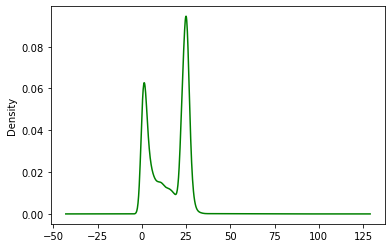

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset["shot_distance"].plot.density(color='green')

<AxesSubplot:ylabel='Density'>

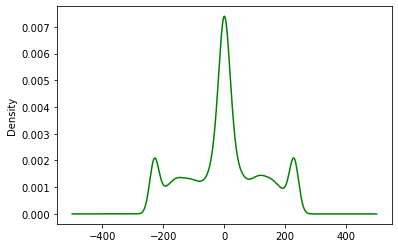

In [112]:
dataset["x"].plot.density(color='green')

<AxesSubplot:ylabel='Density'>

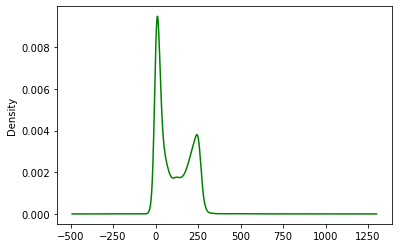

In [113]:
dataset["y"].plot.density(color='green')

<AxesSubplot:ylabel='Density'>

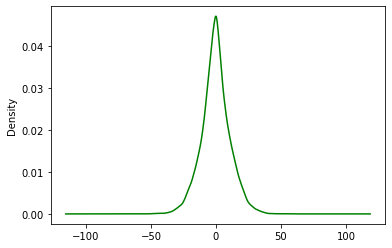

In [114]:
dataset["margin"].plot.density(color='green')

In [115]:
len(dataset.dropna())

51418